In [37]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.special import gammaincinv
from scipy.special import erfinv, erf

#random.seed(2728811529)
random.seed(0)

# Data

In [38]:
data_sample = pd.read_csv("/Users/kanha/BAM_kgupta/Test/T190.0°C_D1000.0hr_S0MPa.csv")
data_legend = "Data"
data_sample = pd.DataFrame(data_sample)
 

resolution = 0.01
binwidth = resolution * resolution
bining = np.arange(min(data_sample["mean_radius_circle_area"]), max(data_sample["mean_radius_circle_area"]) + binwidth, binwidth)

count_w, bin_edges_w = np.histogram(data_sample["mean_radius_circle_area"], bins = bining, density = False)
count_u, bin_edges_u = np.histogram(data_sample["mean_radius_circle_area"], bins = bining, density = True)
#weight = count_u/count_w

#print(weight)
bin_centers = (bin_edges_u[1:] + bin_edges_u[:-1]) / 2
bin_centers = np.round(bin_centers, decimals=6)
area =  np.sum(np.diff(bin_edges_w) * count_w)

print("Area: ", area)
print("bin center", bin_centers)

Area:  0.056300000000004014
bin center [ 0.569404  0.569504  0.569604 ... 13.383404 13.383504 13.383604]


In [39]:
data_sample["mean_radius_circle_area"]

0      1.333336
1      1.513150
2      1.514277
3      5.108182
4      0.655701
         ...   
558    1.608257
559    2.395708
560    4.301705
561    5.557674
562    3.526709
Name: mean_radius_circle_area, Length: 563, dtype: float64

# Log Normal Regression

In [40]:
def Log_normal_pdf(params, X):
    # Unpack the model parameters
    
    rm, sigma = params
    
    # Compute the pdf-value
    pdf_value = (1.0/(np.sqrt(2*np.pi)*X*sigma)*np.exp(-(np.log(X/rm))**2/(2*sigma**2)))
    
    return pdf_value


In [41]:
def Log_normal_regression(params, X):
    # Unpack the model parameters
    
    rm, sigma = params
    
    # Compute the negative log-likelihood
    nll = -np.sum(np.log((1.0/(np.sqrt(2*np.pi)*X*sigma)*np.exp(-(np.log(X/rm))**2/(2*sigma**2)))))
    
    return nll


## Curve fit

In [42]:
def Log_normal_pdf_curvefit(X, rm, sigma):
    # Unpack the model parameters
    
    # Compute the pdf-value
    pdf_value = (1.0/(np.sqrt(2*np.pi)*X*sigma)*np.exp(-(np.log(X/rm))**2/(2*sigma**2)))
    
    return pdf_value


initial_params = [2.1, 0.4]
popt, pcov = curve_fit(Log_normal_pdf_curvefit, bin_centers, count_u, p0 = initial_params)
popt

array([1.64169989, 0.9624149 ])

In [43]:
data_y = count_u
fitted_y = Log_normal_pdf_curvefit(bin_centers, *popt)

fitted_y = np.round(fitted_y, decimals=6)
norm_dist = data_y - fitted_y

print("Mean", np.mean(norm_dist))
print("Standard deviation", np.std(norm_dist))
print(norm_dist)
ks_test_norm = stats.kstest(norm_dist, stats.norm.cdf)
ks_test_norm


Mean 0.011722158884990105
Standard deviation 1.2595710387289931
[ 1.73645603e+01 -3.97439000e-01 -3.97449000e-01 ... -2.87600000e-03
 -2.87600000e-03  1.77591133e+01]


KstestResult(statistic=np.float64(0.4970503710176072), pvalue=np.float64(0.0), statistic_location=np.float64(-0.002876), statistic_sign=np.int8(1))

In [47]:
#random.seed(2728811529)
st0 = np.random.get_state()[1][0]
print("Seed value: ", st0)

# Initial parameter values
initial_params = [2.1, 0.4]

# Perform maximum likelihood regression
result = minimize(Log_normal_regression, initial_params, args=(data_sample["mean_radius_circle_area"],))

# Retrieve the estimated parameters
mu_, sigma_ = result.x

mu_ = np.round(mu_, decimals=6)
sigma_ = np.round(sigma_, decimals=6)

print("Mu :", mu_)
print("Sigma :", sigma_)

#s = random.uniform(0,1,len(data_sample["mean_radius_circle_area"]))
N = 0
while True:
    n = len(data_sample["mean_radius_circle_area"])
    if N == 0:
        N = n
        
    s = random.uniform(0, 1,  N)
    
    # https://www.math.umd.edu/~millson/teaching/STAT400fall18/slides/article13.pdf
    # cdf of log normal distribution

    mu = np.log(mu_)
    sig = sigma_

    ln_d = np.exp(np.sqrt(2)* sig * erfinv(2*s -1) + mu)

    ln_d = ln_d[ln_d <= max(data_sample["mean_radius_circle_area"])]
    ln_d = ln_d[ln_d >= min(data_sample["mean_radius_circle_area"])]

    if len(ln_d) == len(data_sample["mean_radius_circle_area"]):
        break
    else:
        N = N + 1
        

Seed value:  2728811529
Mu : 2.256966
Sigma : 0.775732


In [48]:
Sample_A = data_sample["mean_radius_circle_area"]
Sample_B = np.round(ln_d, decimals=6)

count_A, bin_edges_A = np.histogram(Sample_A, bins = 15, density = False)
count_B, bin_edges_B = np.histogram(Sample_B, bins = 15, density = False)

print("Sample size of data:", len(Sample_A))
print("Sample size of generated data:", len(Sample_B))

#ks_test_ls = stats.ks_2samp(Sample_A, Sample_B)
ks_test_ks = stats.kstest(Sample_A, Sample_B)
p_val_ks = ks_test_ks[1]*100

wasserstein_dist = stats.wasserstein_distance(Sample_A, Sample_B)

chi2_test = stats.chi2_contingency([count_A, count_B])
p_val_chi2 = chi2_test[1]*100


print("KS-test: p-value = ", p_val_ks)
print("Chi2 statistics:", chi2_test)
print("Chi2-test: p-value = ", p_val_chi2)


Sample size of data: 563
Sample size of generated data: 563
KS-test: p-value =  11.662042939719246
Chi2 statistics: Chi2ContingencyResult(statistic=np.float64(14.103625707908257), pvalue=np.float64(0.44201971732954576), dof=14, expected_freq=array([[164.5, 120. ,  67. ,  63.5,  44.5,  31.5,  20.5,  19.5,   9.5,
          9.5,   3. ,   3. ,   3. ,   1.5,   2.5],
       [164.5, 120. ,  67. ,  63.5,  44.5,  31.5,  20.5,  19.5,   9.5,
          9.5,   3. ,   3. ,   3. ,   1.5,   2.5]]))
Chi2-test: p-value =  44.201971732954576


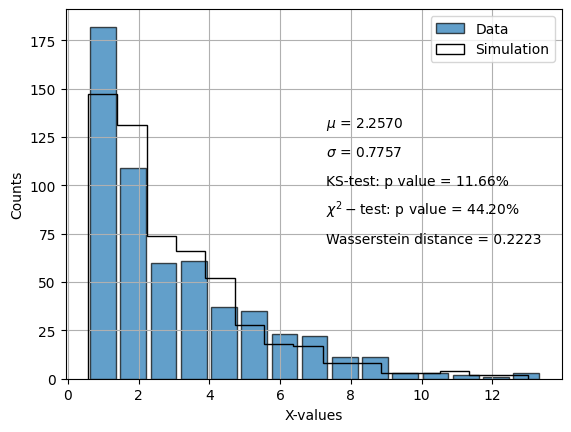

In [49]:
plt.hist(Sample_A, bins = 15,  density=False,  histtype='bar', rwidth= 0.85, edgecolor='black', alpha=0.7, label="Data")
#plt.hist(Sample_B, bins = 15,  density=False,  histtype='bar', rwidth= 0.85, edgecolor='black', alpha=0.1, label="Simulation")
plt.hist(Sample_B, bins = 15,  density=False,  histtype='step', rwidth= 0.85, edgecolor='black', alpha=1.0, label="Simulation")
plt.ylabel("Counts")
plt.xlabel("X-values")
plt.legend()
plt.grid()
#plt.text(8, 180, "Bins = 15")
plt.text(7.3, 130, r"$\mu$ = %.4f"%mu_)
plt.text(7.3, 115, r"$\sigma$ = %.4f"%sigma_)
plt.text(7.3, 100, "KS-test: p value = %.2f"%p_val_ks+"%")
plt.text(7.3, 85, r"$\chi^{2}-$test: p value = %.2f"%p_val_chi2+"%")
plt.text(7.3, 70, "Wasserstein distance = %.4f"%wasserstein_dist)
#plt.savefig("./Images/Coffee_meeting_Data.png",  bbox_inches='tight', dpi=400)
plt.show()

The log nornal distribution function is:

$$ {\frac {1}{x\sigma {\sqrt {2\pi }}}}\ \exp \left(-{\frac {\left(\ln \frac{x}{\mu} \right)^{2}}{2\sigma ^{2}}}\right)$$

$$ \chi^{2} = \sum_{i=1}^{n}\frac{(observed - expected)^{2}}{expected} $$